In [1]:
# Load Modulues
import os

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
import datajoint as dj
from datetime import datetime
import spikeinterface as si
from spikeinterface import widgets, exporters, postprocessing, qualitymetrics, sorters
from workflow.pipeline import *
from workflow.utils.paths import (
    get_ephys_root_data_dir,
    get_raw_root_data_dir,
    get_processed_root_data_dir,
)

import numpy as np
from matplotlib import pyplot as plt


[2024-05-23 15:58:51,970][INFO]: Connecting judewerth@db.datajoint.com:3306
[2024-05-23 15:58:52,825][INFO]: Connected judewerth@db.datajoint.com:3306


In [2]:
# Parameter Dictionaries
Batches = ["Batch 1" , "Batch 2" , "Batch 3"]
Drugs = ["4-AP" , "No Drug" , "Bicuculline" , "Tetrodotoxin"]
Organoids = {
    "Batch 1":["O09" , "O10" , "O11" , "O12"],
    "Batch 2":["O13" , "O14" , "O15" , "O16"],
    "Batch 3":["O17" , "O18" , "O19" , "O20"]
    }


In [1]:
# Random functions

def get_dir_info(clustering_output_dir):
    # take clustering output dir and extract batch , drug_name , organoid , start_time , end_time

    # find organoid , start time , end time
    query = ephys.ClusteringTask() & f"clustering_output_dir = '{clustering_output_dir}'"
    organoid , experiment , start_time , end_time = query.fetch1("organoid_id" , "experiment_start_time" , "start_time" , "end_time")

    # find batch
    if organoid in Organoids["Batch 1"]:
        batch = "Batch 1"
    elif organoid in Organoids["Batch 2"]:
        batch = "Batch 2"
    elif organoid in Organoids["Batch 3"]:
        batch = "Batch 3"
    
    # find drug name
    drug = (culture.Experiment() & f"organoid_id = '{organoid}' AND experiment_start_time = '{experiment}'").fetch1("drug_name")

    info = {
        "batch":batch,
        "drug":drug,
        "organoid":organoid,
        "start_time":start_time,
        "end_time":end_time
        }
    
    return info

def get_nest_dict(data , nest_dict , param , convert=False):
    
    key_order = { # order that each param falls in the key ()
    "batch":0,
    "drug":1,
    "organoid":2,
    "start_time":3,
    "end_time":4
    }

    if not nest_dict: # Create new dictionary based on param

        # Get and Split Key Data
        keys = np.array(list(data.keys()))

        # Split data and get unique values for relative parameter
        split_keys = np.array([key.split('/') for key in keys])

        # Extract keys for specific param
        # If theres 2 parameters in one nest section (marked by "/")
        if "/" in param:

            param_list = param.split("/") # split param up
            param_key_list = split_keys[:,[key_order[p] for p in param_list]] # find the keys for each param
            param_keys = np.array(["/".join(pkey) for pkey in param_key_list]) # combine them into a single param key (ex: 4-AP/O10)

        else:
            
            # Simple extract
            param_keys = split_keys[:,key_order[param]]


        # Find unique values of the parameter
        new_keys = np.unique(param_keys)

        for nkey in new_keys:
            
            # Find the data that corresponds to each unique parameter
            data_keys = keys[param_keys == nkey]

            # If convert is on
            if convert:

                grouped_data =[]
                for dkey in data_keys:
                    grouped_data.append(data[dkey]) # group all data based on the keys in the previous statement
                    
                nest_dict[nkey] = grouped_data # add it to the dictionary

            else:

                nest_dict[nkey] = data_keys # if convert is False simply add the key to the dictionary

    else: # Nest dictionary based on param

        # Find the key and values of the current dict nest level
        old_values = list(nest_dict.values())
        old_keys = list(nest_dict.keys())

        if type(old_values[0]) == dict: # if values are a dict (we need to go back another layer)

            for okey in old_keys:

                # go back another "nest" layer to a new dictionary
                new_dict = nest_dict[okey]

                # try and run the function again at that layer (If that level is a dict too it will keep repeating)
                nest_dict[okey] = get_nest_dict(data=data , nest_dict=new_dict , param=param , convert=convert)

            return nest_dict # Even though the return is here it will run the lines under in different iterations of the function (at lower layers)

        for okey in old_keys:
            
            # Get data to be grouped (for each group)
            keys = nest_dict[okey]

            # split and get unique values
            split_keys = np.array([key.split('/') for key in keys])

            if "/" in param:

                param_list = param.split("/") # split param up
                param_key_list = split_keys[:,[key_order[p] for p in param_list]] # find the keys for each param
                param_keys = np.array(["/".join(pkey) for pkey in param_key_list]) # combine them into a single param key (ex: 4-AP/O10)

            else:

                param_keys = split_keys[:,key_order[param]]

            # Find unique values of the parameter
            new_keys = np.unique(param_keys)

            # Make a new dictionary to group data
            nest_dict[okey] = {}
            for nkey in new_keys:
                
                data_keys = keys[param_keys == nkey]
           
                if convert:

                    grouped_data =[]
                    for dkey in data_keys:
                        grouped_data.append(data[dkey]) # group all data based on the keys in the previous statement
                        
                    nest_dict[okey][nkey] = grouped_data

                else:

                    nest_dict[okey][nkey] = data_keys

    return nest_dict

In [5]:
# Get Data functions
class data:

    def get_tasks(global_key):
        # get clustering tasks which will contain data to be used (time segments and organoids)
        
        # global key = list of dictionaries of wanted Clustering Tasks - [{AND conditions} OR {AND conditions} OR ...]
        #   --> ex: [{"organoid_id":"O09"} , {"organoid_id":"O10" , "start_time":datetime(2023, 5, 18, 12, 25)}]
        #           = all tasks with organoid O09 or tasks with organoid O10 and start time 5/18/2023 , 12:25
        # key options: organoid_id , experiment_start_time , insertion_number , start_time , end_time , paramset_idx , clustering_output_dir

        # Get string key based on global key
        str_key = "" # initialize final string key

        for idx_OR , key in enumerate(global_key): # loop through global key (OR statements)
            
            str_OR = "" # intialize string for keys

            for idx_AND , (param , value) in enumerate(key.items()): # loop through individual keys (AND statements)

                str_AND = f"{param} = '{value}'" # create AND conditions

                if idx_AND == len(key)-1: # if the param,value pair isn't the last one (account for 0)
                    str_OR += str_AND # add onto OR condition without AND statement
                else:
                    str_OR += str_AND + " AND " # add onto OR condition with AND statement
                    
            if idx_OR == len(global_key)-1: # same logic as AND statements
                str_key += str_OR
            else:
                str_key += str_OR + " OR "

        # Extract wanted tasks
        tasks = ephys.ClusteringTask() & str_key
        
        return tasks

    def get_data(Tasks , global_query , Values):
        # get data values based on clustering task

        # Tasks = query of clustering tasks generated by get_tasks
        # global_query = query where to access the data
        # Values = wanted data values (ex: amplitude, firing rate, electrode, waveform)

        data = {}

        for task in Tasks: # loop through wanted values

            # get task info
            clustering_output_dir = task["clustering_output_dir"]
            task_info = get_dir_info(clustering_output_dir=clustering_output_dir)
            task_title = "/".join(map(str, task_info.values()))

            # get task data query
            task_query = global_query & f"organoid_id='{task_info['organoid']}' AND start_time='{task_info['start_time']}' AND end_time='{task_info['end_time']}'"

            if len(task_query) == 0:

                data[task_title] = "no data"

            else:
                
                data[task_title] = {}
                for value in Values: # loop through tasks
                    
                    # extract value data
                    value_data = task_query.fetch(value)

                    # put into dictionary
                    data[task_title][value] = value_data

        return data
    
    def group_data(data , batch=False , drug=False , organoid=False , start_time=False , end_time=False , dict_order=["batch" , "drug" , "organoid" , "start_time" , "end_time"]):
        # group data based on listed parameters (batch , drug , organoid , start_time , end_time)
        # when parameter set to true, the function will group based on that factor
        # assumes the key is batch/drug/organoid/start_time/end_time
        
        # data = input data dictionary --> keys = key (in format listed above) , values = whatever 
        # parameters = logicals
        # dict order = order in which the data will be grouped, each parameter will be a different "nest layer"
        #   ex: ["batch" , "drug" , "organoid"] will sort by batch then drug then organoid with a tripple nested dictionary
        #   if organoid is set to false the function will output a double nested dictionary sorted by batch and drug
        
        #   can use a / to group by 2 factors in one nest level
        #   ex: ["batch" , "drug/organoid"] will output a double nested dictionary grouped by batch then by organoid and drug

        logical_dict = {
            "batch":batch,
            "drug":drug,
            "organoid":organoid,
            "start_time":start_time,
            "end_time":end_time
        }

        # Create order of nest determined by dict_order and logical_dict
        order = []
        for param in dict_order:
            if logical_dict[param]: 

                order.append(param)

        grouped_data = {}
        for param in order: # loops through parameters determined by order

            # if it's the last grouping parameter, convert keys --> data
            if param == order[-1]:
                convert = True
            else:
                convert = False

            # Create grouped data (nested dictionary) based on order (get_nest_dict is a far more complicated function)
            grouped_data = get_nest_dict(data=data , nest_dict=grouped_data , param=param , convert=convert)


        return grouped_data
                

In [ ]:
class format:

    def horhist(data , bins = 50 , key2_order = None):
        # Input double nested data =
        #   First nest = number of plots to be generated
        #   Second nest = number of groups in each plot --> data for those groups
        # bin_data = What bins will be 
        #   if vector --> that's what the bins will be
        #   if int --> number of bins 
        #   if None --> 50 bins
        # key2order = Order which the groups will be ploted, based on the keys of dict2 (nested within dict1)
        #   if None --> will plot in alphabetical order
        #   only keys within key2_order which are also in dict2 will be included 

        dict1 = data # first dictionary (nested)

        # Get bin data (if None provided)
        # Assuming bin data is all the data for the plot (first nest)
        if type(bins) == int:
            
            bin_data = {}
            for key1 , dict2 in dict1.items(): 
                # key1 = first set of nest keys 
                # dict2 = second layer dictionaries within dict1
                
                values = list(dict2.values()) # 3D List

                values_array = np.array(sum(sum(values , []) , [])) # flattened 1D numpy array
                
                _ , key1_bins = np.histogram(values_array , bins=bins) # find bins

                bin_data[key1] = key1_bins # put into global dictionary

        elif type(bins) == list or type(bins) == np.ndarray:
            
            bin_data = {}
            for key1 in dict1.keys():
            
                bin_data[key1] = bins

        elif type(bins) == dict:

            bin_data = bins

        else:
            print("Fix bins input")
            return

        # Reformat data into histogram format
        plot_data = {}
        for key1 , dict2 in dict1.items():

            values_list = []
            if key2_order:

                for key2 in key2_order:
                    if key2 in dict2.keys():
                        
                        values = dict2[key2]

                        values_array = np.array(sum(values , [])) # 2D list --> 1D numpy

                        # Convert to histogram format
                        values_hist , _ = np.histogram(values_array , bins=bin_data[key1])

                        # Put into a list for each drug
                        values_list.append(values_hist)
            
            else:

                for values in dict2.values():
                    
                        values_array = np.array(sum(values , [])) # 2D list --> 1D numpy

                        # Convert to histogram format
                        values_hist , _ = np.histogram(values_array , bins=bin_data[key1])

                        # Put into a list for each drug
                        values_list.append(values_hist)
            
            # Put into global dictionary
            plot_data[key1] = np.array(values_list)
        
        return plot_data , bin_data

In [6]:
# Plot Data functions

class plot:

    def get_bar(bar_data , errorbar = None , points = None , bargap=.2 , groupgap=.2):
        # make bar plot

        # bar_data = height of bars (2D numpy , each 1D are the values for a single group)
        # errorbar = height of errorbar (2D numpy , 0 for no bar)
        # points = any points to be plotted (2D numpy , each 1D numpy is for a group , it's a list of tuples each representing points for a bar)
        # bargap = gap between bars (center to center)
        # groupgap = gap between groups (center to center)

        # Get X values (along x axis)
        numgroup , numbar = bar_data.shape
        xvalues = np.tile(np.arange(numbar)*bargap , (numgroup,1)).astype(float)
        groupoffset = (np.arange(numgroup)[:, np.newaxis]) * (np.ones((1, numbar)) * (groupgap + bargap*numbar))
        xvalues += groupoffset

        # Initialize Axis lists
        bar_ax = []
        error_ax = []
        points_ax = []      

        for i in range(numgroup):
            
            # Get group values and Plot
            x_i = xvalues[i]
            bar_i = bar_data[i]
            bar_ax.append(plt.bar(x_i , bar_i , bargap , edgecolor='k'))
            
            if not errorbar == None:
                error_i = errorbar[i]
                error_ax.append(plt.errorbar(x_i , bar_i , yerr=error_i , fmt='o' , color='k' , capsize=4 , markersize=0))

            if not points == None:
                points_i = points[i]            
                points_ax.append([])
                for ii in range(numbar):
            
                    x_ii = x_i[ii]
                    points_ii = points_i[ii]

                    points_ax[i].append(plt.scatter([x_ii]*len(points_ii) + (np.random.random(len(points_ii)))*(bargap/2)-(bargap/4) , points_ii))

        return bar_ax , error_ax , points_ax
    
    def get_line(line_data , x):
        # get line plot

        # line = 2D numpy , each 1D numpy is a line to be drawn
        # x = 1D numpy , x-axis values

        line_ax = []

        for line in line_data:

            # Plot Data
            line_ax.append(plt.plot(x , line))

        return line_ax
    
    def get_image(image_data):
        # get image plot

        image_ax = plt.imshow(image_data)

        return image_ax
    
    def get_hist(hist_data , bins = None):
        # get histogram plot

        # hist_data = data to be put into histogram plot (don't need to break up into bins before entering)
        # bins = bin values
            # if None --> default
            # if int --> # of bins
            # if 1D numpy or list --> bin values

        hist_ax = plt.hist(hist_data , bins=bins)

        return hist_ax
    
    def get_horhist(horhist_data , bins , groupgap = None):
        # get horizontal histogram plot

        # hist_amp = 2D numpy, each 1D numpy histogram amplitude values based on the bin values for a single group
        # bins = 1D numpy of the bin values for all groups
        # groupgap = gap between groups (baseline to baseline)(default is the max * 1.2)

        # horhist_ax = A nested list of the [[bars for group 1] [bars for group 2] ...]
                
        # determine groupgap if None
        if groupgap == None:
            groupgap = np.max(horhist_data) * 1.2

        # determine bin width
        bindiff = np.diff(bins)
        nbins = len(bindiff)

        # make sure dimensions match
        if not horhist_data.shape[1] == nbins:
            raise Exception("The group histogram amplitude and bin length need to agree (bin = amp+1)")
        
        # set global axis
        horhist_ax = []

        for group , grouphist in enumerate(horhist_data): # loop through groups
            
            # set group axis (with consistent x axis)
            gax = []

            for i in range(nbins): # loop through each bin

                # get plot values (for one bar) 
                plot_hist = [(group*groupgap , grouphist[i])] # (start , height)
                plot_bins = (bins[i] , bindiff[i]) # (start , width)

                # plot (append onto group axis (with individual bars))
                gax.append(plt.broken_barh(plot_hist , plot_bins))

            horhist_ax.append(gax)

        return horhist_ax
    
    def get_figure(nrows , ncols , figure_type , figure_data):
        # nrows = # of rows
        # ncols = # of columns
        # figure_type = dictionary --> key = (row , col) , value = figure type
        # figure_data = dictionary --> key = (row , col) , value = dict of figure data

        # Generate Figure
        fig , ax = plt.subplots(nrows=nrows , ncols=ncols)
        plot_ax = {}

        # Plot data
        for x in range(nrows):

            for y in range(ncols):

                axis_type = figure_type[(x,y)]

                if not axis_type == "no data":
                
                    # Set current axis
                    if nrows == 1:
                        plt.sca(ax[y])
                    elif ncols == 1:
                        plt.sca(ax[x])
                    else:
                        plt.sca(ax[x,y])
                    axis_data = figure_data[(x,y)]

                    if axis_type == "bar":

                        optional_inputs = ["errorbar" , "points" , "bargap" , "groupgap"]
                        for optional_input in optional_inputs:
                            if not optional_input in axis_data:
                                axis_data[optional_input] = None

                        plot_ax[(x,y)] = plot.get_bar(bar_data=axis_data["bar_data"],errorbar=axis_data["errorbar"],points=axis_data["points"],bargap=axis_data["bargap"],groupgap=axis_data["groupgap"])

                    elif axis_type == "line":
                        plot_ax[(x,y)] = plot.get_line(line_data=axis_data["line_data"])

                    elif axis_type == "image":
                        plot_ax[(x,y)] = plot.get_image(image_data=axis_data["image_data"])

                    elif axis_type == "hist":

                        if not "bins" in axis_data:
                            axis_data["bins"] = None

                        plot_ax[(x,y)] = plot.get_hist(hist_data=axis_data["hist_data"] , bins=axis_data["bins"])

                    elif axis_type == "horhist":

                        if not "groupgap" in axis_data:
                            axis_data["groupgap"] = None

                        plot_ax[(x,y)] = plot.get_horhist(horhist_data=axis_data["horhist_data"] , bins=axis_data["bins"] , groupgap=axis_data["groupgap"])

                    else:
                        raise Exception(f"Invalid Plot type at row = {x} and col = {y}")

        return fig , ax , plot_ax





In [80]:
nrows = 3
ncols = 2
plot_type = {}
plot_type[(1,1)] = "hello"

plot_type[(1,1)] == "hello"

True

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x106883f70>>

ValueError: too many values to unpack (expected 2)

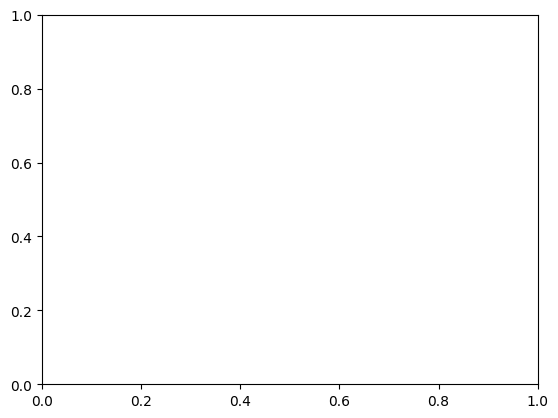

In [45]:
# Data for the broken_barh plot
# Each tuple represents (start, length) of the bars
process1 = [(5, 10), (20, 5), (35, 15)]
process2 = [(0, 5), (15, 10), (30, 5), (40, 10)]
process3 = [(10, 10), (25, 10), (45, 5)]

# Create a figure and an axis
fig, ax = plt.subplots()

# Plot broken bars for each process
ax.broken_barh(process1, process3, facecolors='tab:blue', label='Process 1')


In [7]:
# Get Data Example

global_key = [{"organoid_id":"O09" , "experiment_start_time":datetime(2023, 5, 18, 12, 25)}]
Tasks = data.get_tasks(global_key=global_key)

global_query = ephys.WaveformSet.PeakWaveform()
Values = ["peak_electrode_waveform"]

x = data.get_data(Tasks=Tasks , global_query=global_query , Values=Values)


In [72]:
type(x['Batch 1/4-AP/O09/2023-05-18 12:25:00/2023-05-18 12:30:00'])

dict

In [ ]:
my_dict = {"key1": "value1", "key2": 4, "key3": datetime(2023, 5, 18, 12, 25)}

# Convert dictionary values to a list and join them with "/"
result_string = "/".join(map(str, my_dict.values()))

print(result_string)



value1/4/2023-05-18 12:25:00


In [ ]:
key = {"organoid":4 , "start_time":"hi" , "end_time":3}
f"organoid_id='{key['organoid']}' AND start_time='{3}' AND end_time='{3}'"

# f"file_time BETWEEN '{key['start_time']}' AND '{key['end_time']}'"

"organoid_id='4' AND start_time='3' AND end_time='3'"

In [ ]:
my_dict = extract_dir_info("O09-12_raw/202305181225_202305181230/O09/spykingcircus2_0")
# Convert dictionary values to a list and join them with "/"
result_string = "/".join(map(str, my_dict.values()))

print(result_string)

Batch 1/4-AP/2023-05-18 12:25:00/2023-05-18 12:30:00


In [ ]:
global_query = ephys.QualityMetrics.Cluster()
Values = ['firing_rate' , 'snr']
value = Values[0]

global_query

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,paramset_idx,unit,firing_rate (Hz) firing rate for a unit,snr signal-to-noise ratio for a unit,presence_ratio fraction of time in which spikes are present,isi_violation rate of ISI violation as a fraction of overall rate,number_violation total number of ISI violations,amplitude_cutoff estimate of miss rate based on amplitude histogram,isolation_distance distance to nearest cluster in Mahalanobis space,l_ratio,d_prime Classification accuracy based on LDA,nn_hit_rate Fraction of neighbors for target cluster that are also in target cluster,nn_miss_rate Fraction of neighbors outside target cluster that are in target cluster,silhouette_score Standard metric for cluster overlap,max_drift Maximum change in spike depth throughout recording,cumulative_drift Cumulative change in spike depth throughout recording,contamination_rate
O09,2023-05-18 12:25:00,0,2023-05-18 12:25:00,2023-05-18 12:30:00,0,0,7.57,3.44492,1.0,nan,None,0.0028729,37.12,0.0687267,4.79221,0.872,0.0015,nan,nan,nan,nan
O09,2023-05-18 12:25:00,0,2023-05-18 12:25:00,2023-05-18 12:30:00,0,1,48.1133,2.64645,1.0,nan,None,0.00093204,40.1523,0.102257,4.47733,0.8475,0.002,nan,nan,nan,nan
O09,2023-05-18 12:25:00,0,2023-05-18 12:25:00,2023-05-18 12:30:00,0,2,41.6267,2.76595,1.0,nan,None,0.0101575,19.5597,0.59708,3.87349,0.7235,0.00055,nan,nan,nan,nan
O09,2023-05-18 12:25:00,0,2023-05-18 12:25:00,2023-05-18 12:30:00,0,3,15.58,3.13084,1.0,nan,None,0.00681746,43.4827,0.0623582,4.5024,0.8515,0.0025,nan,nan,nan,nan
O09,2023-05-18 12:25:00,0,2023-05-18 12:25:00,2023-05-18 12:30:00,0,4,49.3067,2.56582,1.0,nan,None,0.00606356,31.5925,0.111974,4.57776,0.8575,0.001125,nan,nan,nan,nan
O09,2023-05-18 12:25:00,0,2023-05-18 12:25:00,2023-05-18 12:30:00,0,5,14.7,3.01465,1.0,nan,None,0.0128314,31.5654,0.126114,4.48018,0.8355,0.000611111,nan,nan,nan,nan
O09,2023-05-18 12:25:00,0,2023-05-18 12:25:00,2023-05-18 12:30:00,0,6,37.34,2.30398,1.0,nan,None,0.0103203,12.283,1.77468,1.06425,0.262,0.114417,nan,nan,nan,nan
O09,2023-05-18 12:25:00,0,2023-05-18 12:25:00,2023-05-18 12:30:00,0,7,63.5467,2.56239,1.0,nan,None,0.00152424,25.7088,0.240307,4.17461,0.781,0.0029,nan,nan,nan,nan
O09,2023-05-18 12:25:00,0,2023-05-18 12:25:00,2023-05-18 12:30:00,0,8,26.4567,2.93525,1.0,nan,None,0.010423,31.2902,0.15173,4.32882,0.8095,0.0013,nan,nan,nan,nan
O09,2023-05-18 12:25:00,0,2023-05-18 12:25:00,2023-05-18 12:30:00,0,9,4.49333,3.67005,1.0,nan,None,0.00915086,22.4424,0.378531,4.30065,0.7675,0.0004,nan,nan,nan,nan
